# 数据预处理

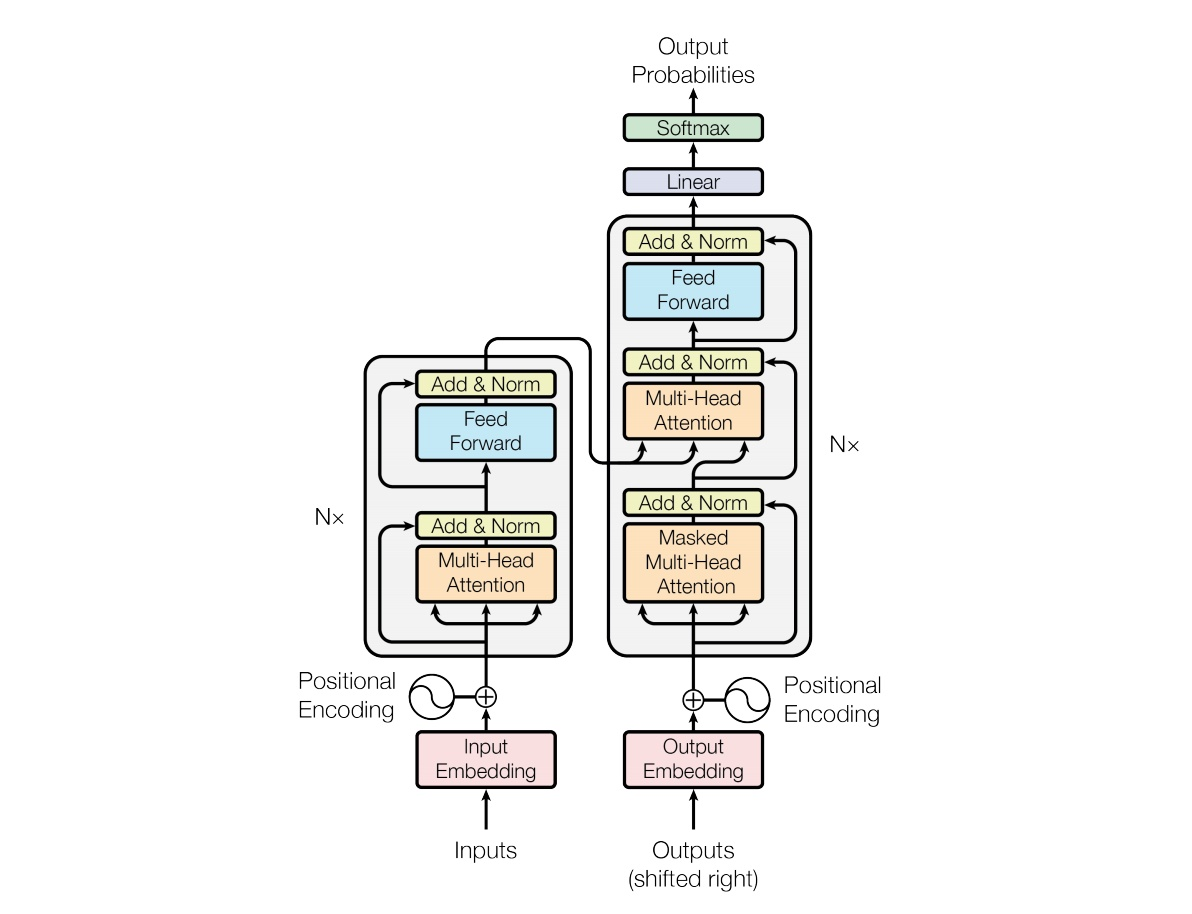

In [1]:
ins = []
outs = []
num = 1000
with open('train.zh','r',encoding = 'utf-8') as f:
    for ind,i in enumerate(f):
        # 适当数据清洗
        i = [tmp for tmp in i.strip() if tmp not in '？，。！ ']
        ins.append(i)
        # 用于快速学习模型，故此处选择1000条数据进行训练
        if ind > num:
            break
            
with open('train.en','r',encoding = 'utf-8') as f:
    for ind,i in enumerate(f):
        # 适当数据清洗
        i = [tmp for tmp in i.strip().strip('.').strip('?').strip(',').split()]
        outs.append(i)
        if ind > num:
            break
            
            
del f,i,ind,num

#基于本地的服务

# bert_client.encode(['<pad>','like']).shape

In [2]:
from collections import defaultdict
from operator import itemgetter
import torch.utils.data as Data
from tqdm import tqdm
import torch.nn as nn
import pickle as pk
import numpy as np
import torch
import math
import os

import time
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.cuda.set_device(0)
else:
    device = torch.device('cpu')
parameter_copy = {
    # 为了加快模型收敛速度，此处调用基于bert模型得到的词向量，所用词向量的维度为768维
    'd_model':768, # Embedding Size
    'epoch':50,
    'alpha':0.01,
    'batch_size':5,
    # 设置序列的最大长度为100
    'max_len':100,
    'd_k':64, #k,q,v的隐层节点数
    'd_q':64,
    'd_v':64,
    'd_ff':2048, #ffn的隐层节点数
    'n_heads':1,
    'n_layers':6,
    # 设置最低频率的词
    'min_count':1,
    # 设置dropout，为防止过拟合
    'dropout':0.1,
    # 配置cpu、gpu
    'device':device,
    # 设置训练学习率
    'lr':0.001,
    # 优化器的参数，动量主要用于随机梯度下降
    'momentum':0.99,
}


def build_vocab(parameter,corpus):
    '''
    parameter:预设的配置项，
    corpus：训练的语料
    本函数的主要作用就是构建字典，包括有编码层的字典及解码层的字典，
    具体来说就是，本模型是数据中文语料进行翻译得到英文语料，即编码层是对中文语料的数据进行编码，解码得到英文语料的结果
    同时，本函数在处理的过程中会去除频率较低的词汇，以及调用基于bert训练好的词向量（对中文英文语料进行编码）
    '''
    global bert_client
    # 准备好用于统计词频的变量
    vocab = defaultdict(int)
    # 配置标志位，包括有补齐位:<PAD>，用于针对不定长的序列进行补齐；未知位:<UNK>，用于推理阶段得到未在字典中出现词汇的异常处理；
    # 起始位:<STA>，结束位:<END>，编解码系列模型的特色，应用于训练阶段于推理阶段，其作用对于编解码系列模型有极为重要的意义
    vocab['<PAD>'] = parameter['min_count']
    vocab['<UNK>'] = parameter['min_count']
    vocab['<STA>'] = parameter['min_count']
    vocab['<END>'] = parameter['min_count']
    # 统计词频
    for i in corpus:
        for j in i:
            vocab[j] += 1
    # 去除低频词
    for i in vocab:
        if vocab[i] < parameter['min_count']:
            del vocab[i]
    # 获取字典大小
    vocab_size = len(vocab)
    # 构建基于词-》id的字典
    voc_index = dict(zip(vocab.keys(),range(len(vocab.keys()))))
    # 构建基于id-》词的字典
    index_voc = dict(zip(range(len(vocab.keys())),vocab.keys()))
    # 调用bert训练好的词向量，若不想使用bert训练好的词向量，此处可替换为onehot形式的编码，模型侧需要添加编码层
    emb_list = bert_client.encode(list(voc_index.keys()))
    return voc_index,index_voc,vocab_size,emb_list

def batch_yield(parameter,ins,outs,shuffle = True):
    '''
    本函数的主要作用是亲手构建一个训练数据的迭代器，功能包括有：
        1、准备好面向于编码层的输入，即模型入参；
        2、准备面向于解码层，用于teacherforce的输入；
        3、准备好面向于解码层的输出，即模型的target（此处的输入输出和teacherforce的输入面向于编解码结构）
        4、在准备好输入输出及用于teacherforce的解码层输入后，对其进行补齐处理，处理成定长
    '''
    device = parameter['device']
    # 此处是一个迭代器，故第一个循环是训练的总批次，epoch
    for epoch in range(parameter['epoch']):
        # 每轮对原始数据进行随机化
        if shuffle:
            permutation = np.random.permutation(len(ins))
            ins = ins[permutation]
            outs = outs[permutation]
        # 准备好一个batch相应的lis（输入输出和teacherforce的输入）
        enc_input_list = []
        dec_input_list = []
        dec_output_list = []
        for items in tqdm(range(len(ins))):
            # 通过语料到id的字典，使用itemgetter批量对其进行处理，最终结果得到基于id的序列
            ids = itemgetter(*ins[items])(parameter['input_voc_index'])
            # 此处是对异常数据进行处理，出现的原因是使用itemgetter时，若序列长度为1则直接返回id，若序列长度大于1则返回元组
            # 为方便后面的处理对直接返回id的情形，替换为补了一个pad的元组
            ids = ids if type(ids) == type(()) else (ids,0)
            # 元组替换为数组，值得注意的是原文中对于编码层的输入也添加了sos，eos，事实上可以不使用
            enc_input_list.append(list(ids))
            # 进行相同的梳理，得到相应基于id的序列
            ids = itemgetter(*outs[items])(parameter['taget_voc_index'])
            # 值得注意的是，这边是必须使用sos和eos，因为训练阶段用于teacherforce的输入和输出必须要错位才可以进行训练，
            # 因此需要sos和eos进行区分错位，而推理阶段，获得编码层结果后进行解码时需要sos起始位开始解码，eos结束位结束推理
            if type(ids) == type(()):
                dec_input_list.append([parameter['taget_voc_index']['<STA>']]+list(ids))
                dec_output_list.append(list(ids)+[parameter['taget_voc_index']['<END>']])
            else:
                dec_input_list.append([parameter['taget_voc_index']['<STA>']]+[ids])
                dec_output_list.append([ids]+[parameter['taget_voc_index']['<END>']])
            # 当该个list大小达到batch_size大小则需要返回相应的数据
            if len(dec_output_list) >= parameter['batch_size']:
                # 先计算输出输出和teacherforce的输入序列的大小
                enc_input_len_list = [len(i) for i in enc_input_list]
                dec_input_len_list = [len(i) for i in dec_input_list]
                dec_output_len_list = [len(i) for i in dec_output_list]
                # 将对应id号替换为提前准备好的对应id号词的词向量
                # 值得注意：我们在使用build_vocab这个函数过程中准备好了词到id的字典和id到词的字典，以及基于id可以得到对应词的词向量
                # 前面的操作中已经把词转换为id，变成了id的序列，这一步工作就是基于id得到对应词的词向量，词向量的序列
                # 同时基于各项序列大小的数组，确定最大的序列长度，对其进行补齐
                enc_input_list = [parameter['input_emb'][i+[0]*(max(enc_input_len_list)-len(i))] for i in enc_input_list]
                dec_input_list = [parameter['target_emb'][i+[0]*(max(dec_input_len_list)-len(i))] for i in dec_input_list]
                dec_output_list = [i+[0]*(max(dec_output_len_list)-len(i)) for i in dec_output_list]
                # 迭代器返回，编码器输入，用于teacherforce的输入，解码器的输出，编码器输入的长度，teacherforce输入的长度，解码器的输入，当前的epoch，是否结束训练的标志
                yield torch.from_numpy(np.array(enc_input_list)).to(device),torch.from_numpy(np.array(dec_input_list)).to(device),torch.from_numpy(np.array(dec_output_list)).to(device).long(),enc_input_len_list,dec_input_len_list,dec_output_len_list,None,True
                # 数据返回后记录清空，重新开始提取数据
                enc_input_list,dec_input_list,dec_output_list = [],[],[]
        # 当前轮的最后，处理方式和上述一致
        enc_input_len_list = [len(i) for i in enc_input_list]
        dec_input_len_list = [len(i) for i in dec_input_list]
        dec_output_len_list = [len(i) for i in dec_output_list]
        enc_input_list = [parameter['input_emb'][i+[0]*(max(enc_input_len_list)-len(i))] for i in enc_input_list]
        dec_input_list = [parameter['target_emb'][i+[0]*(max(dec_input_len_list)-len(i))] for i in dec_input_list]
        dec_output_list = [i+[0]*(max(dec_output_len_list)-len(i)) for i in dec_output_list]
        yield torch.from_numpy(np.array(enc_input_list)).to(device),torch.from_numpy(np.array(dec_input_list)).to(device),torch.from_numpy(np.array(dec_output_list)).to(device).long(),enc_input_len_list,dec_input_len_list,dec_output_len_list,epoch,True
    # 完成所有轮数据的提取
    yield None,None,None,None,None,None,None,False

# 因为考虑到部分同学没有配置BertClient，无法直接调用bert训练好的词向量，因此这边提前配置好用于训练的相关参数
# 不要每次调用bert
if not os.path.exists('parameter.pkl'):
    from bert_serving.client import BertClient
    bert_client = BertClient()
    parameter = parameter_copy
    # 构建相关字典和对应的基于bert的词向量
    input_voc_index,input_index_voc,input_vocab_size,input_emb = build_vocab(parameter,ins)
    taget_voc_index,taget_index_voc,taget_vocab_size,target_emb = build_vocab(parameter,outs)
    # 将所获取的字典及对应词向量放置于parameter中，所有过程统一使用parameter进行处理
    parameter['input_voc_index'] = input_voc_index
    parameter['input_index_voc'] = input_index_voc
    parameter['taget_voc_index'] = taget_voc_index
    parameter['taget_index_voc'] = taget_index_voc
    parameter['input_vocab_size'] = input_vocab_size
    parameter['taget_vocab_size'] = taget_vocab_size
    parameter['input_emb'] = input_emb
    parameter['target_emb'] = target_emb
    del input_voc_index,input_index_voc,input_vocab_size,taget_voc_index,taget_index_voc,taget_vocab_size,input_emb,target_emb,bert_client,parameter_copy
    pk.dump(parameter,open('parameter.pkl','wb'))
else:
    # 读取已经处理好的parameter，但是考虑到模型训练的参数会发生变化，
    # 因此此处对于parameter中模型训练参数进行替换
    parameter = pk.load(open('parameter.pkl','rb'))
    for i in parameter_copy.keys():
        if i not in parameter:
            parameter[i] = parameter_copy[i]
            continue
        if parameter_copy[i] != parameter[i]:
            parameter[i] = parameter_copy[i]
    for i in parameter_copy.keys():
        print(i,':',parameter[i])
    pk.dump(parameter,open('parameter.pkl','wb'))
    del parameter_copy,i
    
data_set = batch_yield(parameter,np.array(ins),np.array(outs))
batch_x,batch_y,batch_y2,x_len,y_len,y2_len,epoch,keys = next(data_set)
batch_x.shape,batch_y.shape,x_len,y_len

D:\Anaconda3-5.3\envs\nlp\lib\site-packages\ipykernel_launcher.py:181: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

  0%|                                                                                         | 0/1002 [00:00<?, ?it/s]

d_model : 768
epoch : 50
alpha : 0.01
batch_size : 5
max_len : 100
d_k : 64
d_q : 64
d_v : 64
d_ff : 2048
n_heads : 1
n_layers : 6
min_count : 1
dropout : 0.1
device : cuda:0
lr : 0.001
momentum : 0.99


(torch.Size([5, 17, 768]),
 torch.Size([5, 14, 768]),
 [17, 8, 15, 6, 9],
 [12, 6, 8, 6, 14])

In [3]:
print(ins[0])
print(outs[0])

['一', '对', '丹', '顶', '鹤', '正', '监', '视', '着', '它', '们', '的', '筑', '巢', '领', '地']
['A', 'pair', 'of', 'red', '-', 'crowned', 'cranes', 'have', 'staked', 'out', 'their', 'nesting', 'territory']


# 模型构建

## 位置层

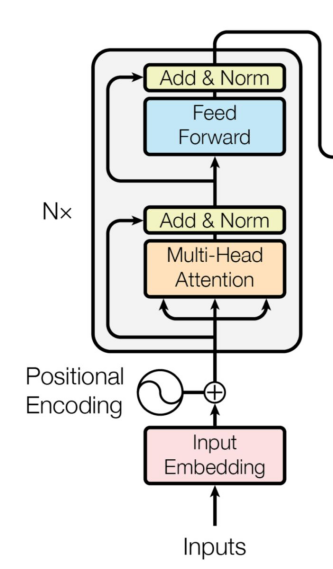

$$PE(pos,2i) = sin(\frac{pos}{10000^{\frac{2i}{d_{model}}}})$$

$$PE(pos,2i+1) = cos(\frac{pos}{10000^{\frac{2i}{d_{model}}}})$$

- Question：
    1. 位置层的作用？
        - 位置编码是Transformer框架中特有的组成部分，补充了Attention机制本身不能捕捉位置信息的缺陷
        
    2. 为什么用正余弦函数来处理位置层？
        - $论文中使用的Positional Encoding(PE)是正余弦函数，位置(pos)越小，波长越长，每一个位置对应的PE都是唯一的。同时作者也提到，之所以选用正余弦函数作为PE，是因为这可以使得模型学习到token之间的相对位置关系。因为对于任意一个偏移量K，PE_(pos+k)可以由PE_(pos)线性表示，差了几个\pi /2$
    
    3. 位置层如何使用？
        - $Positional Embedding的成分直接叠加于Embedding之上，使得每个token的位置信息和它的语义信息(embedding)充分融合，并被传递到后续所有经过复杂变换的序列表达中去。$

In [11]:
import torch
import math
d_model = 768
a = [round(1/(10000**(2*i/d_model)),7) for i in range(10)]
b = list(torch.exp(torch.arange(0, 20, 2).float() * (-math.log(10000.0) / d_model)).numpy())
print(a)
print(b)

[1.0, 0.9763001, 0.9531619, 0.930572, 0.9085176, 0.8869858, 0.8659643, 0.8454411, 0.8254042, 0.8058422]
[1.0, 0.9763001, 0.9531619, 0.93057203, 0.9085176, 0.88698584, 0.86596435, 0.84544104, 0.82540417, 0.80584216]


$$e^{-log(10000)*2i/d_model} = e^{log(10000^{-2i/d_model})} = 10000^{-2i/d_model} = 1/10000^{2i/d_model}$$

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, parameter):#d_model, dropout=0.1, max_len=200):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=parameter['dropout'])
        d_model = parameter['d_model']
        max_len = parameter['max_len']

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # 位置向量的表示可以参考上图
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        '''
        x: [seq_len, batch_size, d_model]
        '''
        # 词向量的编码加上位置向量
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
def get_attn_pad_mask(q_len_list, k_len_list):
    global device
    len_q = max(q_len_list)
    len_k = max(k_len_list)
    batch_size = len(q_len_list)
    pad_attn_mask =  torch.from_numpy(np.array([[False]*i+[True]*(len_k-i) for i in k_len_list])).unsqueeze(1)
    return pad_attn_mask.expand(batch_size, len_q, len_k).byte().to(device)  # [batch_size, len_q, len_k]
    

In [5]:
# have a test
test = PositionalEncoding(parameter).to(device)
mask = get_attn_pad_mask(x_len,x_len)
batch_x.shape,test(batch_x).shape,mask.shape

(torch.Size([50, 23, 768]),
 torch.Size([50, 23, 768]),
 torch.Size([50, 23, 23]))

## block（multi-head self attention + Add & Normalize + Feed Forward Network）

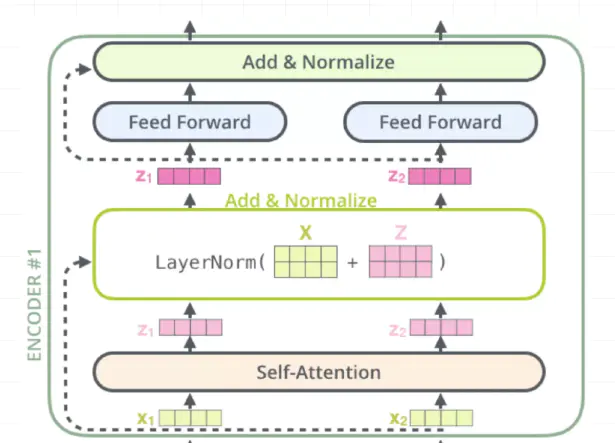

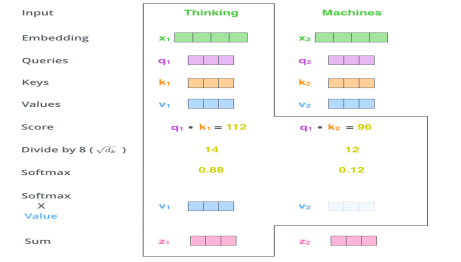

### *multi-head self attention + ADD & Normalize

$Attention通常可以进行如下描述，表示为将query(Q)和key-value pairs映射到输出上，其中query、每个key、每个value都是向量，输出是V中所有values的加权，其中权重是由Query和每个key计算出来的，计算方法分为三步：$

- $1.计算比较Q和K的相似度，用f来表示：$

$$f(Q,K_{i})_{i = 1,2,3}$$
- $2.将得到的相似度进行softmax归一化：$

$$\alpha_{i} = \frac{e^{f(Q,K_{i})}}{\sum_{j = 1}^{m}e^{f(Q,K_{i})}}_{j = 1,2,3}$$
- $3.针对计算出来的权重，对所有的values进行加权求和，得到Attention向量：$

$$\sum_{i=1}^{m}\alpha_{i}V_{i}$$
-  $ex1.相似度的计算有以下4种：$
    
$$点乘 dot product： f(Q,K_{i}) = Q^TK_{i}$$
$$权重 General： f(Q,K_{i}) = Q^TWK_{i}$$
$$拼接权重 Concat： f(Q,K_{i}) = W[Q^T;K_{i}]$$
$$感知器 Perceptron： f(Q,K_{i}) = V^Ttanh(WQ+UK_{i})$$

- $ex2.Q、K、V意义：$

$$其中Q、K、V是输入通过一层全连接得到，相当于W_{Q}^TX、W_{K}^TX、W_{V}^TX$$

- $整个过程相当于：$

$输入（768维的词向量序列）通过全连接，分别映射至Q、K、V（64*nheads维度上），通过Q^TK点乘得到Q和K之间的相似度，然后通过softmax得到Q在K上各个得分，Softmax(Q^TK)，这个softmax的分数决定了当前单词在每个句子中每个单词位置的表示程度；然后V^T(Q^TK)，这里实际上的意义在于保存对当前词的关注度不变的情况下，降低对不相关词的关注。$

In [4]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self,parameter):
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = parameter['d_k']

    def forward(self, Q, K, V, attn_mask):
        '''
        Q: [batch_size, n_heads, len_q, d_k]
        K: [batch_size, n_heads, len_k, d_k]
        V: [batch_size, n_heads, len_v(=len_k), d_v]
        attn_mask: [batch_size, n_heads, seq_len, seq_len]
        '''
        # 基于上述公式进行点乘相似度
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(self.d_k)
        scores.masked_fill_(attn_mask, -1e9) 
        # 经过softmax输出的是注意力或者说打分结果
        attn = nn.Softmax(dim=-1)(scores)
        # 与类似于原始输入相乘，来强化或者减弱其中的特征
        context = torch.matmul(attn, V) # [batch_size, n_heads, len_q, d_v]
        return context, attn
    
class MultiHeadAttention(nn.Module):
    def __init__(self,parameter):
        super(MultiHeadAttention, self).__init__()
        device = parameter['device']
        self.d_q,self.d_k,self.d_v,self.d_model,self.n_heads = parameter['d_q'],parameter['d_k'], \
        parameter['d_v'],parameter['d_model'],parameter['n_heads']
        self.W_Q = nn.Linear(self.d_model, self.d_q * self.n_heads, bias=False)
        self.W_K = nn.Linear(self.d_model, self.d_k * self.n_heads, bias=False)
        self.W_V = nn.Linear(self.d_model, self.d_v * self.n_heads, bias=False)
        self.fc = nn.Linear(self.n_heads * self.d_v, self.d_model, bias=False)
        self.sdp = ScaledDotProductAttention(parameter).to(device)
        self.add_norm = nn.LayerNorm(self.d_model)
        
    def forward(self, input_Q, input_K, input_V, attn_mask):
        '''
        input_Q: [batch_size, len_q, d_model]
        input_K: [batch_size, len_k, d_model]
        input_V: [batch_size, len_v(=len_k), d_model]
        attn_mask: [batch_size, seq_len, seq_len]
        '''
        # 所谓的多头自注意机制，就是输入的内容都一致，然后通过三个不同的线性变换得到我们的QKV，然后基于点乘相似度（点乘得分函数）
        # 进行计算得到相应相应的注意力来强化或者减弱不同头的特征
        residual, batch_size = input_Q, input_Q.size(0)
        # 原始输入经过不同线性变化得到QKV
        Q = self.W_Q(input_Q).view(batch_size, -1, self.n_heads, self.d_q).transpose(1,2)  # Q: [batch_size, n_heads, len_q, d_q]
        K = self.W_K(input_K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)  # K: [batch_size, n_heads, len_k, d_k]
        V = self.W_V(input_V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1,2)  # V: [batch_size, n_heads, len_v(=len_k), d_v]
        attn_mask_new = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1) # attn_mask : [batch_size, n_heads, seq_len, seq_len]
        # 基于点乘相似度得到经过注意力加成后的结果（经过强化或者减弱其中特征）
        context, attn = self.sdp(Q, K, V, attn_mask_new)
        context = context.transpose(1, 2).reshape(batch_size, -1, self.n_heads * self.d_v) # context: [batch_size, len_q, n_heads * d_v]
        # 交给全连接进行线性变化
        output = self.fc(context) # [batch_size, len_q, d_model]
        # add+ln
        output = self.add_norm(output + residual)
        return output, attn

In [7]:
mha = MultiHeadAttention(parameter).cuda()
mask = get_attn_pad_mask(x_len,x_len)
out = mha(seqs,seqs,seqs,mask)

- Question：
    1. Multi-Head Attention的作用？
        - 将模型分为多个头，期望其形成多个相互独立子空间，可以让模型去关注不同方面的信息。但是也有很多论文不这么认为。也有人认为是计算复杂度的取舍。同时multi-head相对来说也比较冗余，mask掉一定比例的head对结果影响不大
        
    2. LN、BN作用和区别？
        - 一般深度网络中的数据维度是[N,H,W,C](图像上),[N,S,C](自然语言上，S为序列长度)，其中N为batch_size,C为隐层或者说特征层的维度，所谓的BN即是在batch上进行归一化，所谓的LN则是在隐层这个维度上进行归一化
    
    3. 为什么nlp任务上很少用BN呢？
        - 
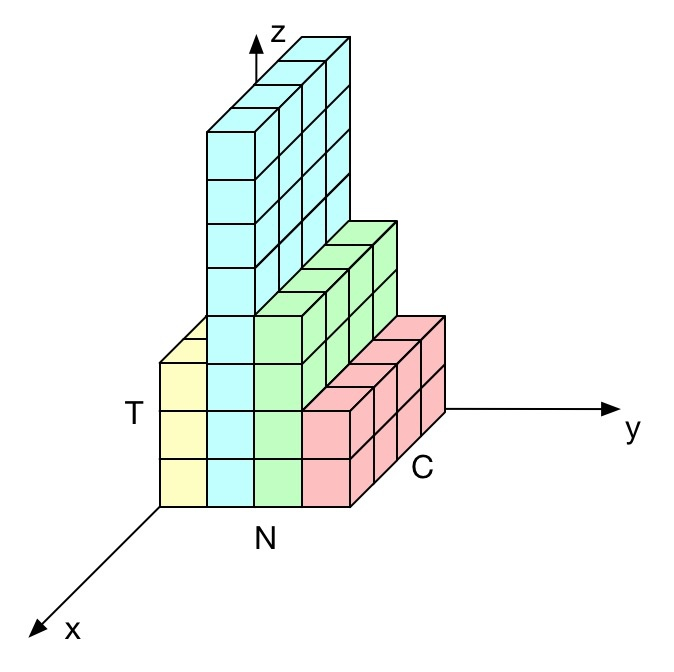
在上图中每个颜色表示一个训练样本，每个样本都有自己的长度。BN是按与y轴平行的方向计算统计量（即[N,T]）。由于BN中每个样本的长度都不一样，计算的$\mu$和$\sigma$时就会非常不具有代表性，当t>3时，我们只能获得来自第二个样本的一个统计量，那么此时的均值和方差已经没有意义。LN是按与x轴平行的方向做归一化（即[C,T]），这个被证明是在RNN中表现比较好的一种归一化方法，因为在每个时间片都会获得相同的数量（通道数）个数值的归一化统计量。LN中不同时间片的$\mu$和$\sigma$是共享的。

### Feed Forward Network

In [5]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self,parameter):
        self.d_ff,self.d_model = parameter['d_ff'],parameter['d_model']
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(self.d_model, self.d_ff, bias=False),
            nn.ReLU(),
            nn.Linear(self.d_ff, self.d_model, bias=False)
        )
        self.add_norm = nn.LayerNorm(self.d_model)
    def forward(self, inputs):
        '''
        inputs: [batch_size, seq_len, d_model]
        '''
        residual = inputs
        # 所谓的ffn就是两次线性变化，中间一个激活函数，提供的就是非线性结果，加强模型表现，也可以去除；
        # 值得注意的是bert里面ffn使用的激活函数是glu
        output = self.fc(inputs)
        return self.add_norm(output + residual) # [batch_size, seq_len, d_model]

- Question：
    1. Feed Forward Network的作用？
        - 其实，FFN的加入引入了非线性(ReLu激活函数)，变换了attention output的空间, 从而增加了模型的表现能力。把FFN去掉模型也是可以用的，但是效果差了很多。

## 编码层

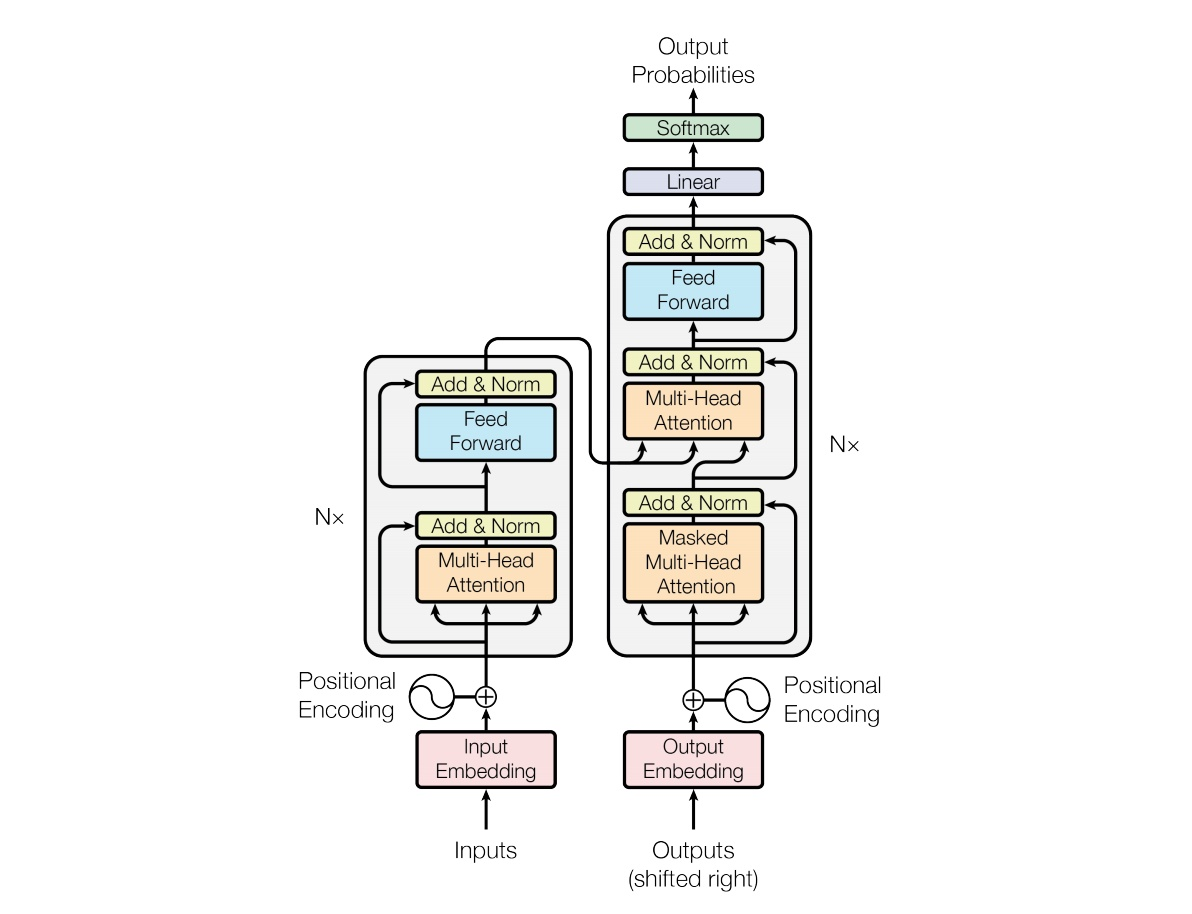

In [6]:
# 多头注意力机制+ffn构成一个transformerEncoder，多个transformerEncoder，可以理解为多个lstm
class EncoderLayer(nn.Module):
    def __init__(self,parameter):
        super(EncoderLayer, self).__init__()
        device = parameter['device']
        self.enc_self_attn = MultiHeadAttention(parameter).to(device)
        self.pos_ffn = PoswiseFeedForwardNet(parameter).to(device)

    def forward(self, enc_inputs, enc_self_attn_mask):
        '''
        enc_inputs: [batch_size, src_len, d_model]
        enc_self_attn_mask: [batch_size, src_len, src_len]
        '''
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size, src_len, d_model]
        return enc_outputs, attn

In [7]:
# 在多个transformerEncoder上补上原始词embedding和位置embedding
class Encoder(nn.Module):
    def __init__(self,parameter):
        super(Encoder, self).__init__()
        n_layers = parameter['n_layers']
        self.pos_emb = PositionalEncoding(parameter)
        self.layers = nn.ModuleList([EncoderLayer(parameter) for _ in range(n_layers)])

    def forward(self, enc_inputs,len_inputs):
        '''
        enc_inputs: [batch_size, src_len, d_model]
        '''
        enc_outputs = self.pos_emb(enc_inputs.transpose(0, 1)).transpose(0, 1) # [batch_size, src_len, d_model]
        enc_self_attn_mask = get_attn_pad_mask(len_inputs, len_inputs) # [batch_size, src_len, src_len]
        enc_self_attns = []
        # 多个transformerEncoder进行特征提取，不断加强或者减弱对应特征
        for layer in self.layers:
            # 有点类似于最后一层隐层的输出和历史的注意力状态
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

In [13]:
# hvae a test
test = Encoder(parameter).to(device)
context,attns = test(batch_x,x_len)
batch_x.shape,context.shape

(torch.Size([50, 23, 768]), torch.Size([50, 23, 768]))

## 解码层

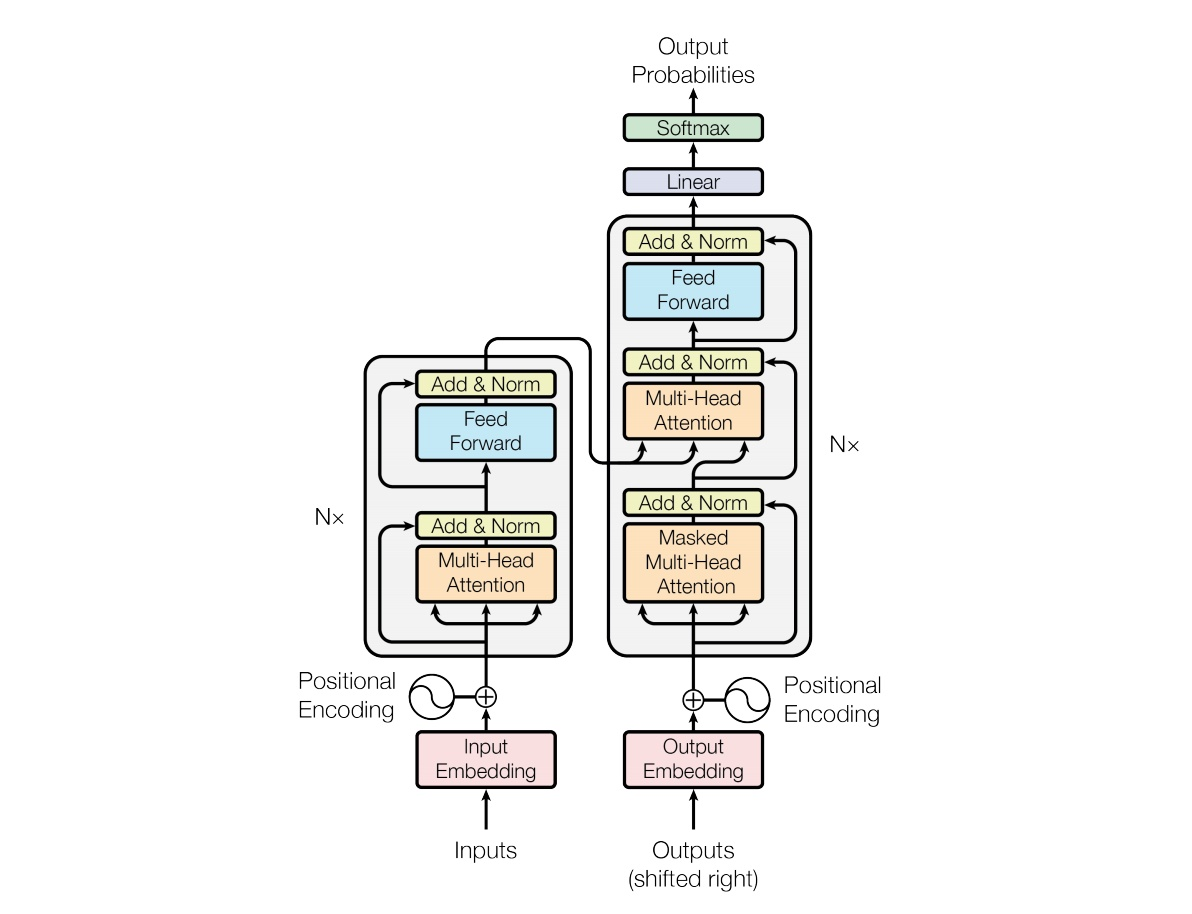

In [8]:
# 所谓的解码就是2个多头注意力机制+1个ffn
class DecoderLayer(nn.Module):
    def __init__(self,parameter):
        super(DecoderLayer, self).__init__()
        device = parameter['device']
        self.dec_self_attn = MultiHeadAttention(parameter)
        self.dec_enc_attn = MultiHeadAttention(parameter)
        self.pos_ffn = PoswiseFeedForwardNet(parameter)

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        '''
        dec_inputs: [batch_size, tgt_len, d_model]
        enc_outputs: [batch_size, src_len, d_model]
        dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
        dec_enc_attn_mask: [batch_size, tgt_len, src_len]
        '''
        # 这里和seq2seq一样完全teacherforce，如果使用部分可以随机化其中部分词
        # 其中这里的处理需要参考上图，第一个多头注意力机制输入是，都是用于teacherforce的输入；
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        # 第二个多头注意机制，其中两头内容是编码器的输出，一个是第一个多头注意力机制的输出
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        # 最后通过一个ffn输出最后结果
        dec_outputs = self.pos_ffn(dec_outputs) # [batch_size, tgt_len, d_model]
        return dec_outputs, dec_self_attn, dec_enc_attn

In [15]:
test = DecoderLayer(parameter).to(device)
batch_x.shape,batch_x.shape,get_attn_pad_mask(x_len,x_len).shape,get_attn_pad_mask(x_len,x_len).shape

(torch.Size([50, 23, 768]),
 torch.Size([50, 23, 768]),
 torch.Size([50, 23, 23]),
 torch.Size([50, 23, 23]))

In [9]:
# 完整的解码器也包括有位置层那块的编码，原因是teacherforce的输入，然后就是加上上面解码层的transformerDecoder，
# 中间有涉及到掩码可暂时不用管
def get_attn_subsequence_mask(seq):
    '''
    seq: [batch_size, tgt_len]
    '''
    global device
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1) # Upper triangular matrix
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()
    return subsequence_mask.to(device) # [batch_size, tgt_len, tgt_len]

class Decoder(nn.Module):
    def __init__(self,parameter):
        super(Decoder, self).__init__()
        n_layers = parameter['n_layers'] 
        self.pos_emb = PositionalEncoding(parameter)
        self.layers = nn.ModuleList([DecoderLayer(parameter) for _ in range(n_layers)])

    def forward(self, dec_inputs, len_dec_inputs,len_enc_inputs, enc_outputs):
        '''
        dec_inputs: [batch_size, tgt_len]
        enc_intpus: [batch_size, src_len]
        enc_outputs: [batsh_size, src_len, d_model]
        '''
        dec_outputs = self.pos_emb(dec_inputs.transpose(0, 1)).transpose(0, 1) # [batch_size, tgt_len, d_model]
        dec_self_attn_pad_mask = get_attn_pad_mask(len_dec_inputs, len_dec_inputs) # [batc_size, tgt_len, tgt_len]
        dec_self_attn_subsequence_mask = get_attn_subsequence_mask(dec_inputs) # [batch_size, tgt_len, tgt_len]
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequence_mask), 0) # [batch_size, tgt_len, tgt_len]
        dec_enc_attn_mask = get_attn_pad_mask(len_dec_inputs, len_enc_inputs) # [batc_size, tgt_len, src_len]
        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len], dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
#             print(dec_outputs.shape, enc_outputs.shape, dec_self_attn_mask.shape, dec_enc_attn_mask.shape)
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

In [19]:
# have a test
test = Decoder(parameter).to(device)
enc = Encoder(parameter).to(device)
context,attns = enc(batch_x,x_len)
dec_outputs, dec_self_attns, dec_enc_attns = test(batch_y,y_len,x_len,context)
dec_outputs.shape,batch_y.shape

(torch.Size([50, 15, 768]), torch.Size([50, 15, 768]))

## 完成transformer

In [10]:
# 所谓的transformer结构上和seq2seq基本一致，只是采用的特征提取器是基于多头注意力机制和ffn的
class Transformer(nn.Module):
    def __init__(self,parameter):
        device = parameter['device']
        d_model = parameter['d_model']
        taget_vocab_size = parameter['taget_vocab_size']
        super(Transformer, self).__init__()
        self.encoder = Encoder(parameter).to(device)
        self.decoder = Decoder(parameter).to(device)
        self.projection = nn.Linear(d_model, taget_vocab_size, bias=False).to(device)
    def forward(self, enc_inputs,len_inputs, dec_inputs,len_dec_inputs):
        enc_outputs, enc_self_attns = self.encoder(enc_inputs,len_inputs)
        # 这里需要注意，做法的seq2seq一致训练时候，因为知道完整的输入和输出因此可以直接处理，但是推理阶段，因为不知道，所以需要逐个处理
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs,len_dec_inputs, len_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs) # dec_logits: [batch_size, tgt_len, tgt_vocab_size]
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns
    
# 这样就完成了完整 的transformer

In [21]:
test = Transformer(parameter).to(parameter['device'])
a = test(batch_x,x_len,batch_y,y_len)
a[0].shape,batch_y.shape

(torch.Size([750, 2257]), torch.Size([50, 15, 768]))

# 模型训练

In [11]:
import os
import shutil
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# 记录日志
# shutil.rmtree('transformer') if os.path.exists('transformer') else 1
writer = SummaryWriter('./transformer', comment='transformer')

# 构建模型
model = Transformer(parameter).to(parameter['device'])

# 确定训练模式
model.train()

# 确定优化器和损失
optimizer = torch.optim.SGD(model.parameters(),lr=parameter['lr'], momentum=parameter['momentum'], nesterov=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# 准备迭代器
train_yield = batch_yield(parameter,np.array(ins),np.array(outs))

# 记录loss
loss_cal = []
min_loss = float('inf')

while 1:
    batch_x,batch_y,batch_y2,x_len,y_len,y2_len,epoch,keys = next(data_set)
    if keys:
        outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(batch_x,x_len,batch_y,y_len)
        loss = criterion(outputs, batch_y2.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_cal.append(loss.item())
        if epoch is not None:
            if (epoch+1)%1 == 0:
                loss_cal = sum(loss_cal)/len(loss_cal)
                if loss_cal < min_loss:
                    min_loss = loss_cal
                    torch.save(model.state_dict(), 'model-transformer.h5')
                print('epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, \
                                                       parameter['epoch'],loss_cal))
            loss_cal = [loss.item()]
            scheduler.step()
        
    else:
        break

D:\Anaconda3-5.3\envs\nlp\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3-5.3\envs\nlp\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3-5.3\envs\nlp\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3-5.3\envs\nlp\lib\site-packages\tensorboard\compat\tensorflow_stub\dty

epoch [1/50], Loss: 6.1365


  1%|▊                                                                               | 10/1002 [00:00<00:12, 82.19it/s]

epoch [2/50], Loss: 5.6586


  1%|▊                                                                               | 10/1002 [00:00<00:12, 78.33it/s]

epoch [3/50], Loss: 5.3134


  1%|▊                                                                               | 10/1002 [00:00<00:12, 79.58it/s]

epoch [4/50], Loss: 5.0779


  1%|▊                                                                               | 10/1002 [00:00<00:13, 72.13it/s]

epoch [5/50], Loss: 4.8899


  1%|▊                                                                               | 10/1002 [00:00<00:14, 69.15it/s]

epoch [6/50], Loss: 4.6649


  1%|▊                                                                               | 10/1002 [00:00<00:12, 81.52it/s]

epoch [7/50], Loss: 4.4322


  1%|▊                                                                               | 10/1002 [00:00<00:12, 77.13it/s]

epoch [8/50], Loss: 4.1963


  1%|▊                                                                               | 10/1002 [00:00<00:14, 69.57it/s]

epoch [9/50], Loss: 3.9898


  1%|▊                                                                               | 10/1002 [00:00<00:13, 73.73it/s]

epoch [10/50], Loss: 3.7418


  1%|▊                                                                               | 10/1002 [00:00<00:14, 69.15it/s]

epoch [11/50], Loss: 3.4705


  1%|▊                                                                               | 10/1002 [00:00<00:12, 76.54it/s]

epoch [12/50], Loss: 3.2443


  1%|▊                                                                               | 10/1002 [00:00<00:13, 74.88it/s]

epoch [13/50], Loss: 3.0100


  1%|▊                                                                               | 10/1002 [00:00<00:13, 74.27it/s]

epoch [14/50], Loss: 2.8005


  1%|▊                                                                               | 10/1002 [00:00<00:12, 77.13it/s]

epoch [15/50], Loss: 2.5669


  1%|▊                                                                               | 10/1002 [00:00<00:13, 75.39it/s]

epoch [16/50], Loss: 2.3799


  1%|▊                                                                               | 10/1002 [00:00<00:12, 82.19it/s]

epoch [17/50], Loss: 2.1832


  1%|▊                                                                               | 10/1002 [00:00<00:14, 67.29it/s]

epoch [18/50], Loss: 2.0315


  1%|▊                                                                               | 10/1002 [00:00<00:12, 78.95it/s]

epoch [19/50], Loss: 1.8672


  1%|▊                                                                               | 10/1002 [00:00<00:13, 71.62it/s]

epoch [20/50], Loss: 1.7460


  1%|▊                                                                               | 10/1002 [00:00<00:12, 77.73it/s]

epoch [21/50], Loss: 1.6314


  1%|▊                                                                               | 10/1002 [00:00<00:13, 72.67it/s]

epoch [22/50], Loss: 1.4628


  1%|▊                                                                               | 10/1002 [00:00<00:12, 80.86it/s]

epoch [23/50], Loss: 1.3580


  1%|▊                                                                               | 10/1002 [00:00<00:12, 77.73it/s]

epoch [24/50], Loss: 1.2471


  1%|▊                                                                               | 10/1002 [00:00<00:12, 79.58it/s]

epoch [25/50], Loss: 1.2121


  1%|▊                                                                               | 10/1002 [00:00<00:13, 72.15it/s]

epoch [26/50], Loss: 1.1460


  1%|▊                                                                               | 10/1002 [00:00<00:12, 82.19it/s]

epoch [27/50], Loss: 1.0954


  1%|▊                                                                               | 10/1002 [00:00<00:13, 71.11it/s]

epoch [28/50], Loss: 1.0956


  1%|▊                                                                               | 10/1002 [00:00<00:13, 75.96it/s]

epoch [29/50], Loss: 1.0204


  1%|▊                                                                               | 10/1002 [00:00<00:12, 77.13it/s]

epoch [30/50], Loss: 1.0032


  1%|▊                                                                               | 10/1002 [00:00<00:13, 74.25it/s]

epoch [31/50], Loss: 0.9360


  1%|▊                                                                               | 10/1002 [00:00<00:13, 73.19it/s]

epoch [32/50], Loss: 0.9022


  1%|▊                                                                               | 10/1002 [00:00<00:12, 80.21it/s]

epoch [33/50], Loss: 0.8455


  1%|▊                                                                               | 10/1002 [00:00<00:13, 73.73it/s]

epoch [34/50], Loss: 0.8655


  1%|▊                                                                               | 10/1002 [00:00<00:12, 81.52it/s]

epoch [35/50], Loss: 0.8213


  1%|▊                                                                               | 10/1002 [00:00<00:12, 78.95it/s]

epoch [36/50], Loss: 0.7878


  1%|▊                                                                               | 10/1002 [00:00<00:12, 76.52it/s]

epoch [37/50], Loss: 0.7513


  1%|▊                                                                               | 10/1002 [00:00<00:13, 73.17it/s]

epoch [38/50], Loss: 0.7559


  1%|▊                                                                               | 10/1002 [00:00<00:13, 72.14it/s]

epoch [39/50], Loss: 0.7170


  1%|▊                                                                               | 10/1002 [00:00<00:12, 78.95it/s]

epoch [40/50], Loss: 0.7211


  1%|▊                                                                               | 10/1002 [00:00<00:12, 82.19it/s]

epoch [41/50], Loss: 0.6890


  1%|▊                                                                               | 10/1002 [00:00<00:13, 73.73it/s]

epoch [42/50], Loss: 0.6792


  1%|▊                                                                               | 10/1002 [00:00<00:12, 80.21it/s]

epoch [43/50], Loss: 0.6495


  1%|▊                                                                               | 10/1002 [00:00<00:12, 77.71it/s]

epoch [44/50], Loss: 0.6501


  1%|▊                                                                               | 10/1002 [00:00<00:14, 67.31it/s]

epoch [45/50], Loss: 0.6420


  1%|▊                                                                               | 10/1002 [00:00<00:13, 72.14it/s]

epoch [46/50], Loss: 0.6491


  1%|▊                                                                               | 10/1002 [00:00<00:12, 81.74it/s]

epoch [47/50], Loss: 0.6173


  1%|▊                                                                               | 10/1002 [00:00<00:12, 78.33it/s]

epoch [48/50], Loss: 0.6054


  1%|▊                                                                               | 10/1002 [00:00<00:13, 75.39it/s]

epoch [49/50], Loss: 0.6009


100%|██████████████████████████████████████████████████████████████████████████████| 1002/1002 [00:12<00:00, 77.83it/s]


epoch [50/50], Loss: 0.6044
